<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw1/data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [3]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [4]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [5]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [6]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [7]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

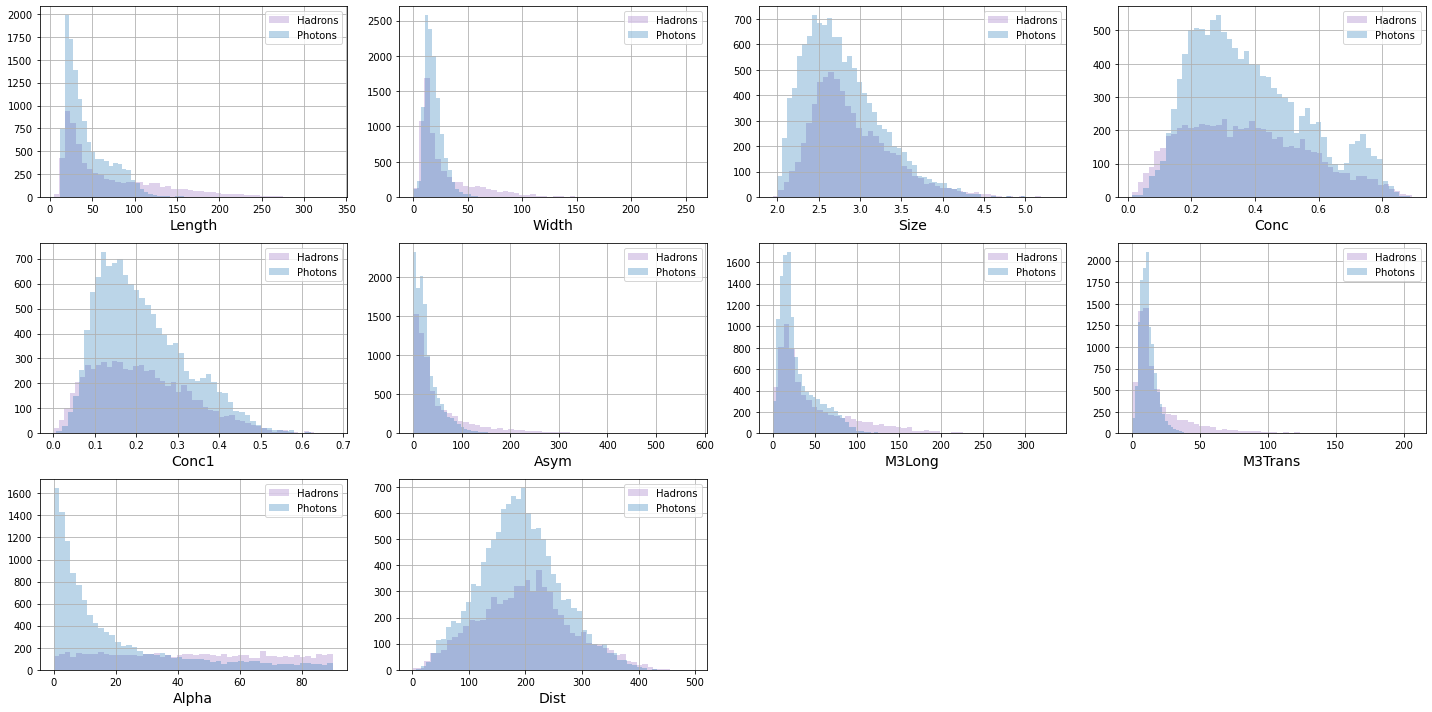

In [8]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

In [9]:
import random, os
import torch

def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(123)

# Обучающая и тестовая выборки

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

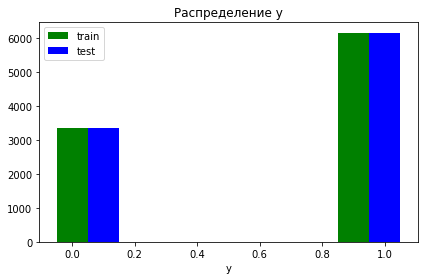

In [319]:
plt.hist(y_train, align='left', label='train', color="g")
plt.hist(y_test, align='right', label='test', color="b")
plt.legend()
plt.title('Распределение у')
plt.xlabel('y')
plt.tight_layout()

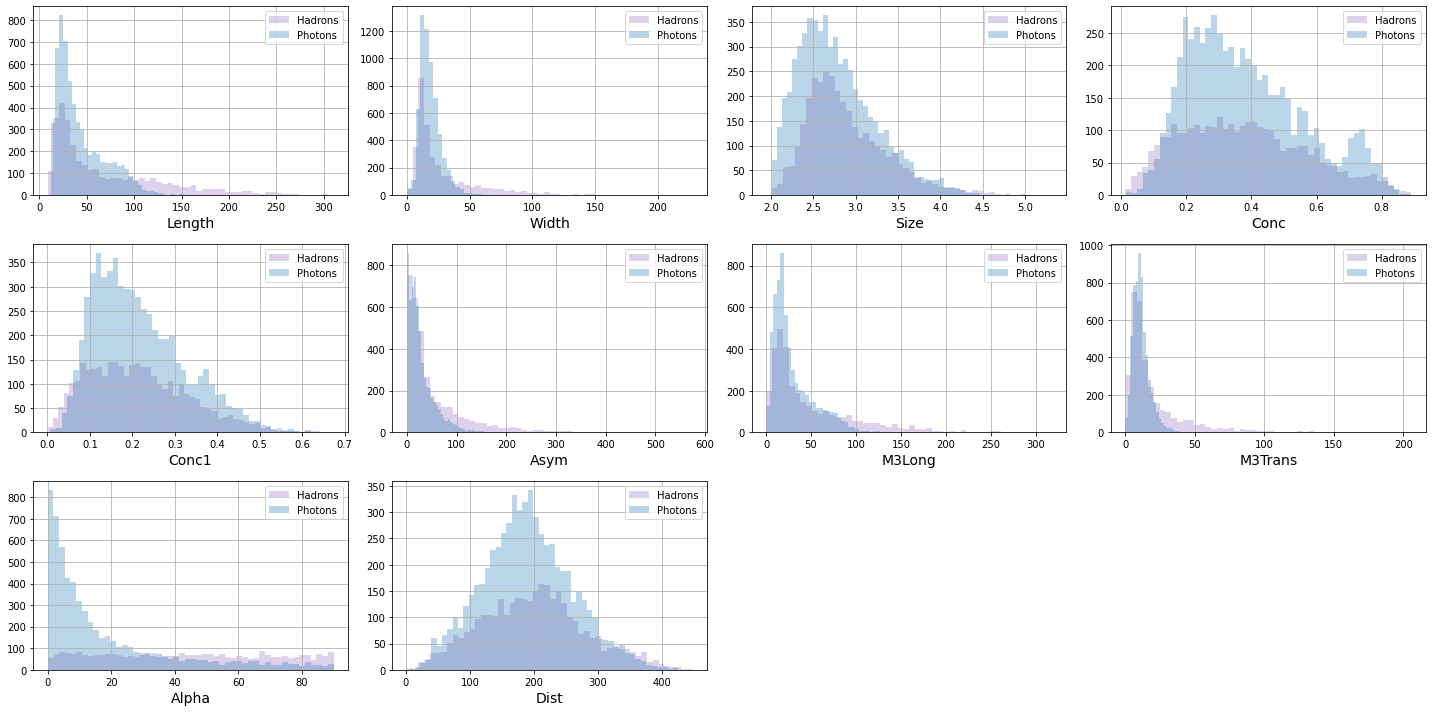

In [11]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

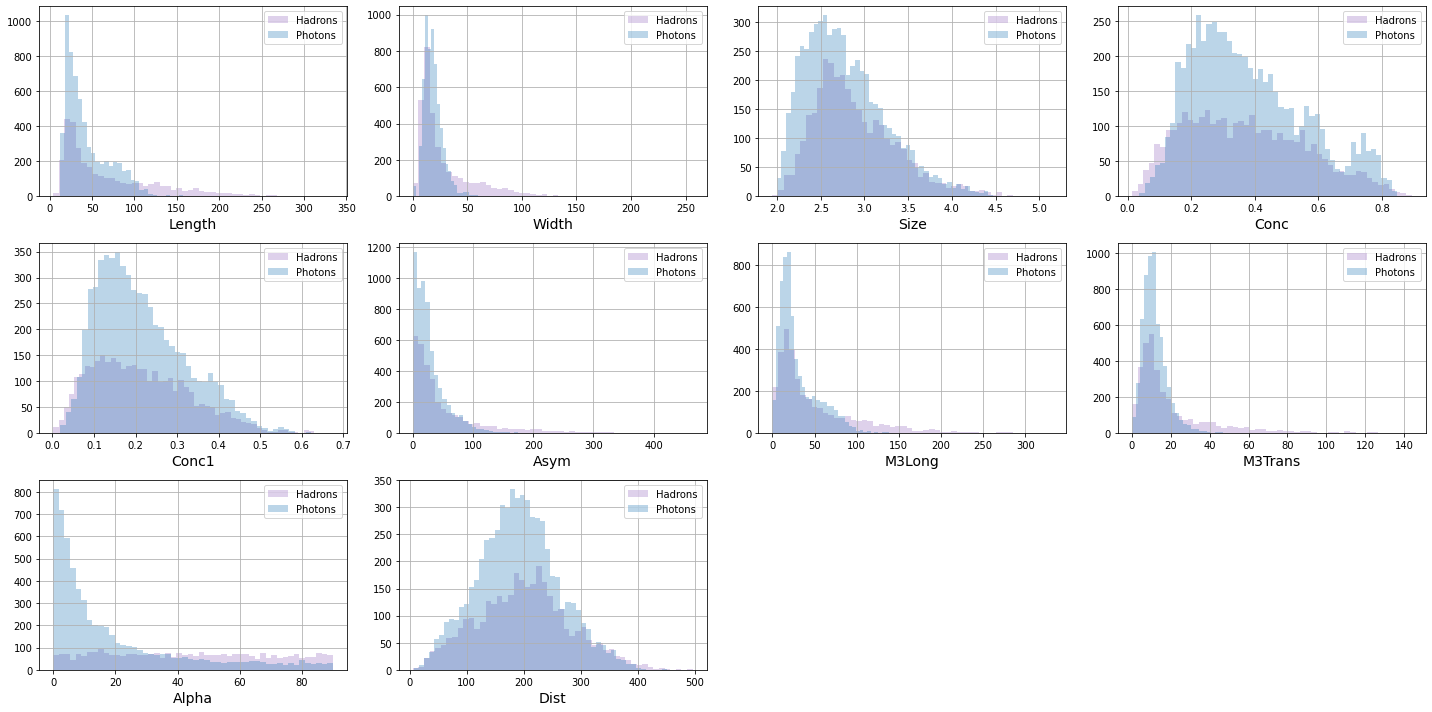

In [12]:
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [13]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)

X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

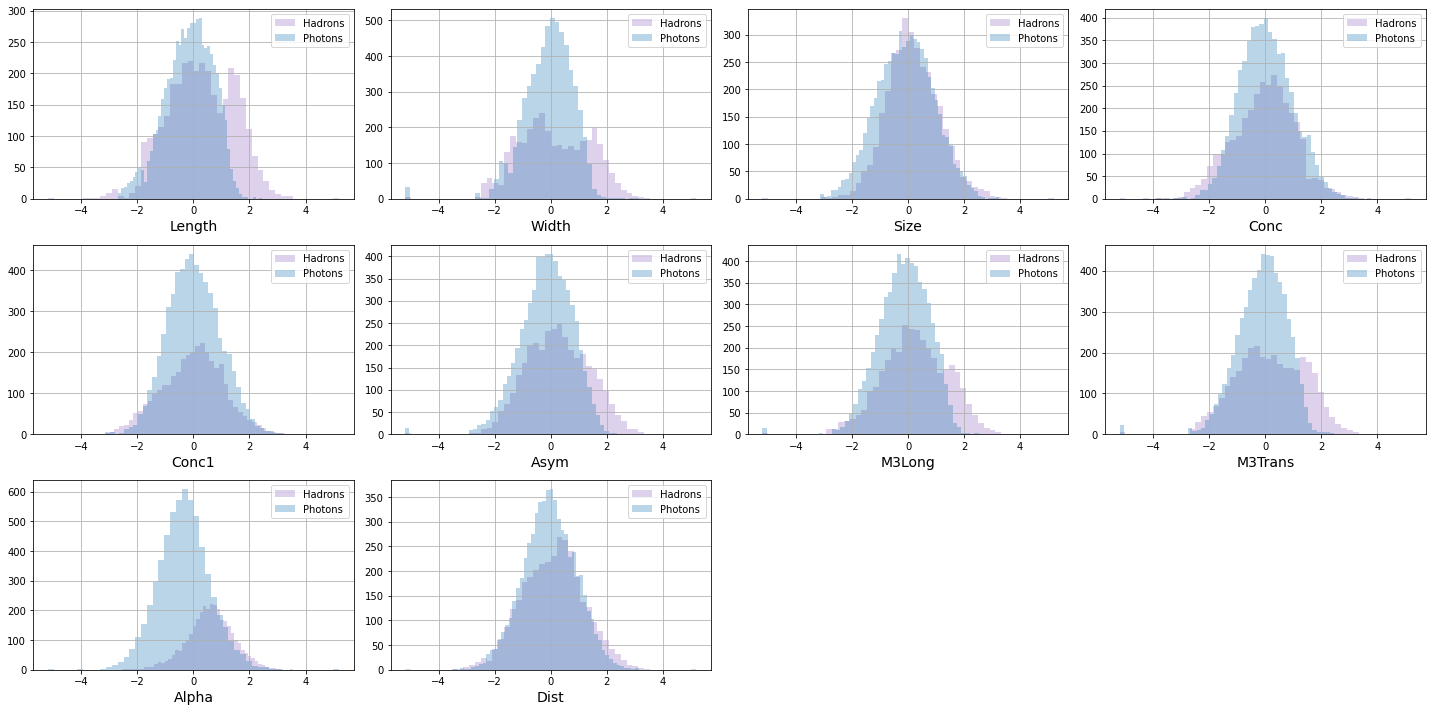

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

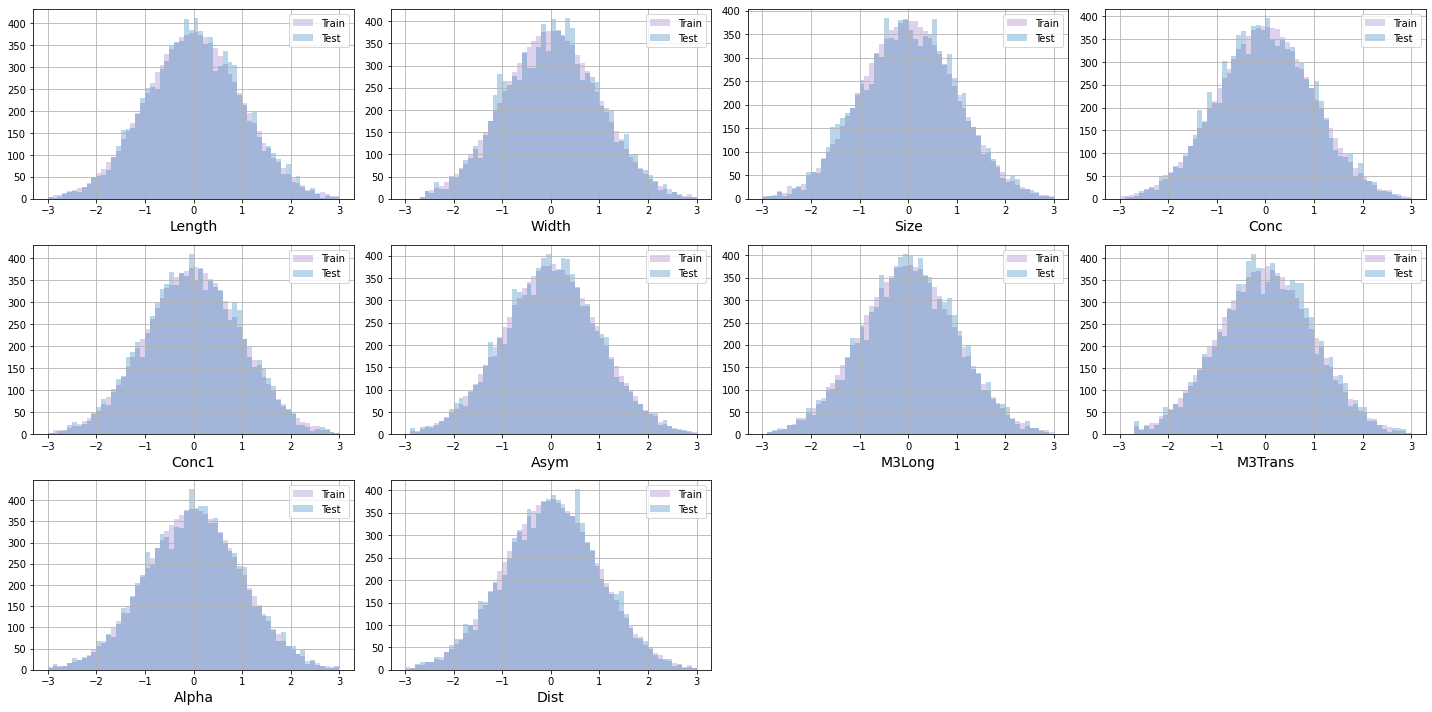

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
DEVICE

device(type='cpu')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [18]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, self.n_outputs),
        )
        
    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [19]:
def generate(generator, y, latent_dim):
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    z = torch.normal(0, 1, size=(len(y), latent_dim))
    X_fake = generator(z, y)
    return X_fake.cpu().detach().numpy()  

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [20]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        self.n_inputs = n_inputs

        self.net = nn.Sequential(
            nn.Linear(self.n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        for p in self.parameters():
            p.data.clamp_(-0.01, 0.01)
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Функция активации в конце дискриминатора - сигмоида. Дискриминатор выдает вероятность принадлежности фейкового объекта к реальному. Сигмоида нормирует результаты так, чтоб они лежали в интервале от 0 до 1. Сигмоида заставляет модель исправлять ошибки.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X_train, X_test, y_train, y_test = train_test_split(
        np.concatenate([X_real, X_fake]), np.concatenate([y_real, y_fake]), 
        stratify = np.concatenate([y_real, y_fake]), test_size=0.25, shuffle = True, random_state = 11
    )   
    
    reg = LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train, y_train.ravel())
    lin_reg_score = reg.score(X_test, y_test)

    clf = GradientBoostingClassifier().fit(X_train, y_train.ravel())
    boosting_score = clf.score(X_test, y_test)

    print('Logistic regression score: ' + str(lin_reg_score))
    print('Boosting score: ' + str(boosting_score))

Идеальное акураси в данном случае равно распределению классов в выборке. Так как у нас кол-во фейковых объектов равно кол-ву реальных, то и идеальное акураси равно 0,5. Это будет обозначать, что классификаторы не справляются с разделением объектов реальных и сгенерированных, а значит генерация успешная. 

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [22]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        iter_i = 0
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                num_objects = real_batch.size(0)

                Z_noise = torch.normal(0, 1, (num_objects, self.latent_dim))
                gen_objects = self.generator(Z_noise, cond_batch)

                all_obj_loss = self.discriminator(torch.cat([real_batch, gen_objects], dim=0), torch.cat([cond_batch, cond_batch], dim=0))
                real_objects_loss, gen_objects_loss = torch.split(all_obj_loss, num_objects)

                if iter_i % self.n_critic == 0:
                    self.opt_gen.zero_grad()
                    gen_loss = -torch.mean(gen_objects_loss)
                    gen_loss.backward()
                    self.opt_gen.step()

                else:
                    self.opt_disc.zero_grad()
                    discr_loss = torch.mean(gen_objects_loss) - torch.mean(real_objects_loss)
                    discr_loss.backward()
                    self.opt_disc.step()
          
                iter_i += 1

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())
            
            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score

            XX_real, _, yy_real, _ = train_test_split(X_real, y_cond, stratify = y_cond, train_size=1000, shuffle = True)
            XX_fake, _, yy_fake, _ = train_test_split(X_fake, y_cond, stratify = y_cond, train_size=1000, shuffle = True)

            XX_real = XX_real.cpu().detach().numpy()
            XX_fake = XX_fake.cpu().detach().numpy()
            yy_real = yy_real.cpu().detach().numpy()
            yy_fake = yy_fake.cpu().detach().numpy()

            other_agent_score(XX_real, yy_real, XX_fake, yy_fake)
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [23]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Logistic regression score: 0.728
Boosting score: 0.738
Logistic regression score: 0.712
Boosting score: 0.746
Logistic regression score: 0.73
Boosting score: 0.742
Logistic regression score: 0.736
Boosting score: 0.748
Logistic regression score: 0.694
Boosting score: 0.706
Logistic regression score: 0.704
Boosting score: 0.706
Logistic regression score: 0.722
Boosting score: 0.744
Logistic regression score: 0.71
Boosting score: 0.728
Logistic regression score: 0.716
Boosting score: 0.71
Logistic regression score: 0.718
Boosting score: 0.736
Logistic regression score: 0.79
Boosting score: 0.78
Logistic regression score: 0.754
Boosting score: 0.754
Logistic regression score: 0.764
Boosting score: 0.756
Logistic regression score: 0.766
Boosting score: 0.776
Logistic regression score: 0.782
Boosting score: 0.794
Logistic regression score: 0.798
Boosting score: 0.816
Logistic regression score: 0.834
Boosting score: 0.84
Logistic regression score: 0.804
Boosting score: 0.806
Logistic regress

<ipython-input-24-684ea810ad15>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


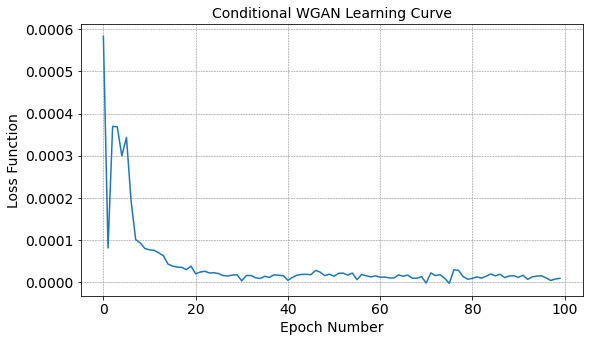

In [24]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [25]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [26]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

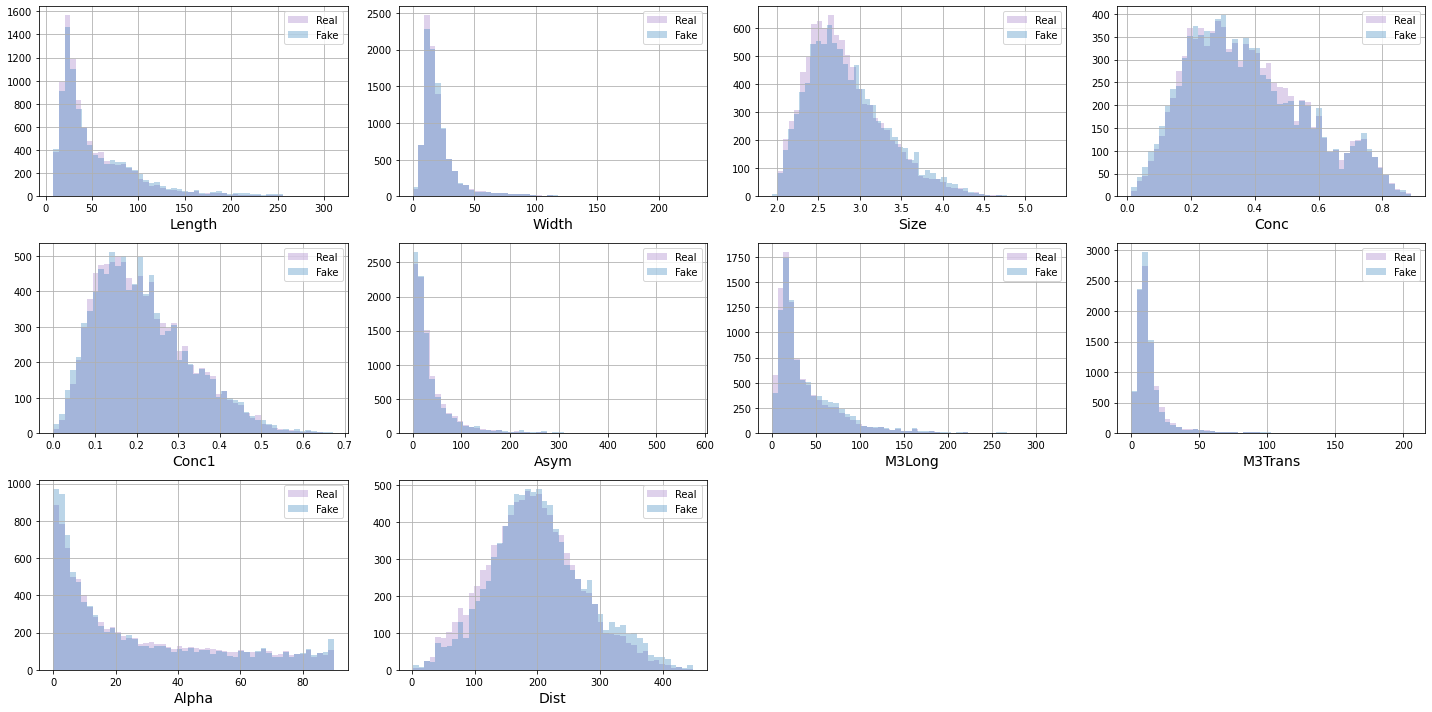

In [27]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [28]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

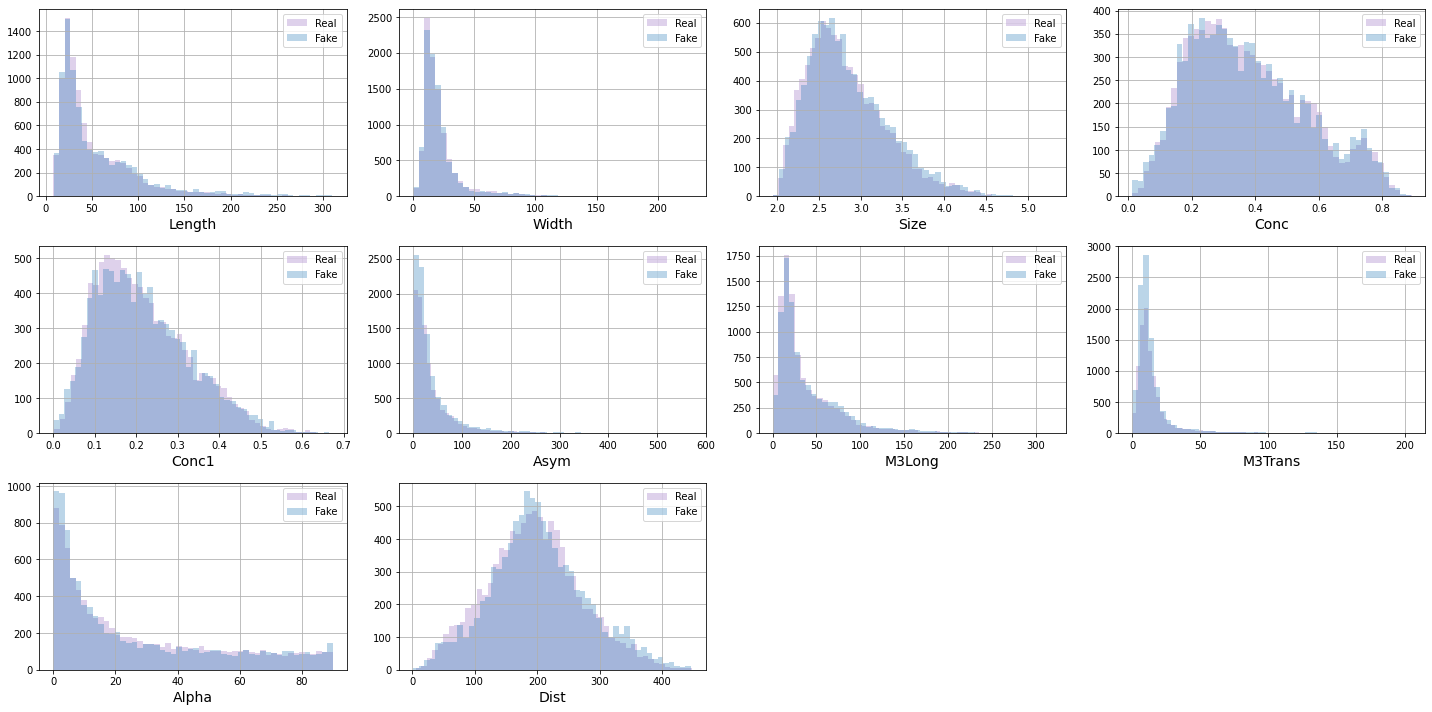

In [29]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2023/hw/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [30]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [32]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6987392594656573


In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_proba.round(), normalize=False) / len(yy_test)
print("ROC AUC =", auc)
print("accuracy =", acc)

ROC AUC = 0.6987392594656573
accuracy = 0.639695057833859


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Получились достойные результаты. Конечно, площадь под рок кривой больше 0.5, но и далеко не 1. Сгенерированные данные очень похожи на настоящие, классификатору тяжело их разделить. Это показывает и акураси. По графикам распределения одного из параметров видна похожесть сгенерированного распределения на реальное распределение данных.

Напомню, идеально аук рок и акураси 0,5.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [263]:
def corrupt(x, amount):
    noise = torch.rand_like(x)
    x = x*(1-amount) + noise*amount
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [264]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


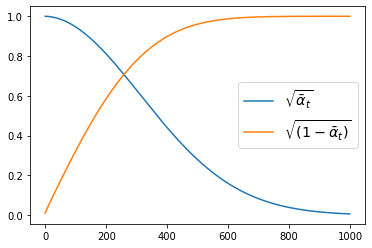

In [265]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=3)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

In [266]:
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.13.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 3,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [308]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [282]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )      

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [295]:
def generate_with_diffusion(model, y, latent_dim, sheduler):

    n_steps = sheduler.num_train_timesteps

    x = torch.rand(len(y), latent_dim).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)

    for i in range(n_steps):
        with torch.no_grad():                             
            pred = model(x, y)  

        mix_factor = 1 / (n_steps - i)                   
        x = x * (1 - mix_factor) + pred * mix_factor

    return x.cpu().detach().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [309]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic = 5
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.loss_fn = nn.MSELoss()
        self.n_critic = n_critic
        self.scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample_range=3)

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit 
        for epoch in range(self.n_epochs):
            loss_epoch = []
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                num_objects = real_batch.size(0)

                noise = torch.randn_like(real_batch)
                #noisy_x = corrupt(real_batch, noise)

                timesteps = torch.randint(0, 99, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = self.scheduler.add_noise(real_batch, noise, timesteps)

                gen_objects = self.model(noisy_x, cond_batch)
                gen_loss = self.loss_fn(gen_objects, real_batch)

                self.opt_gen.zero_grad()
                gen_loss.backward()
                self.opt_gen.step()
                
                loss_epoch.append(gen_loss)
          
            self.loss_history.append(sum(loss_epoch) / len(loss_epoch))

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score
            XX_real, _, yy_real, _ = train_test_split(X_real, y_cond, stratify = y_cond, train_size=1000, shuffle = True) 
            XX_real = XX_real.cpu().detach().numpy()
            yy_real = yy_real.cpu().detach().numpy()

            _, _, yy_fake, _ = train_test_split(X_real, y_cond, stratify = y_cond, train_size=1000, shuffle = True) 
            yy_fake = yy_fake.cpu().detach().numpy()
            XX_fake = generate_with_diffusion(self.model, yy_fake, self.latent_dim, self.scheduler)
            
            if epoch % self.n_critic == 0:
                other_agent_score(XX_real, yy_real, XX_fake, yy_fake)
            
        # Turn off training
        self.model.train(False)

In [285]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Logistic regression score: 0.812
Boosting score: 0.838
Logistic regression score: 0.72
Boosting score: 0.74
Logistic regression score: 0.672
Boosting score: 0.748
Logistic regression score: 0.75
Boosting score: 0.758
Logistic regression score: 0.73
Boosting score: 0.736
Logistic regression score: 0.694
Boosting score: 0.752
Logistic regression score: 0.686
Boosting score: 0.786
Logistic regression score: 0.718
Boosting score: 0.784
Logistic regression score: 0.724
Boosting score: 0.71
Logistic regression score: 0.734
Boosting score: 0.754
Logistic regression score: 0.724
Boosting score: 0.75
Logistic regression score: 0.7
Boosting score: 0.738
Logistic regression score: 0.742
Boosting score: 0.766
Logistic regression score: 0.746
Boosting score: 0.78
Logistic regression score: 0.712
Boosting score: 0.752
Logistic regression score: 0.714
Boosting score: 0.732
Logistic regression score: 0.74
Boosting score: 0.774
Logistic regression score: 0.726
Boosting score: 0.766
Logistic regression 

<ipython-input-311-6db1bc9c07d8>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


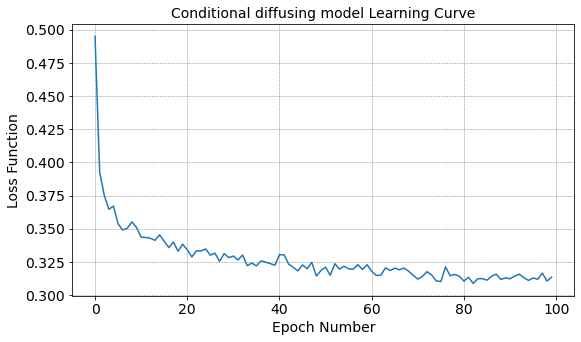

In [311]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(torch.tensor(diffusionFitter.loss_history).detach().numpy())
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [300]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)

In [301]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, diffusionFitter.scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)

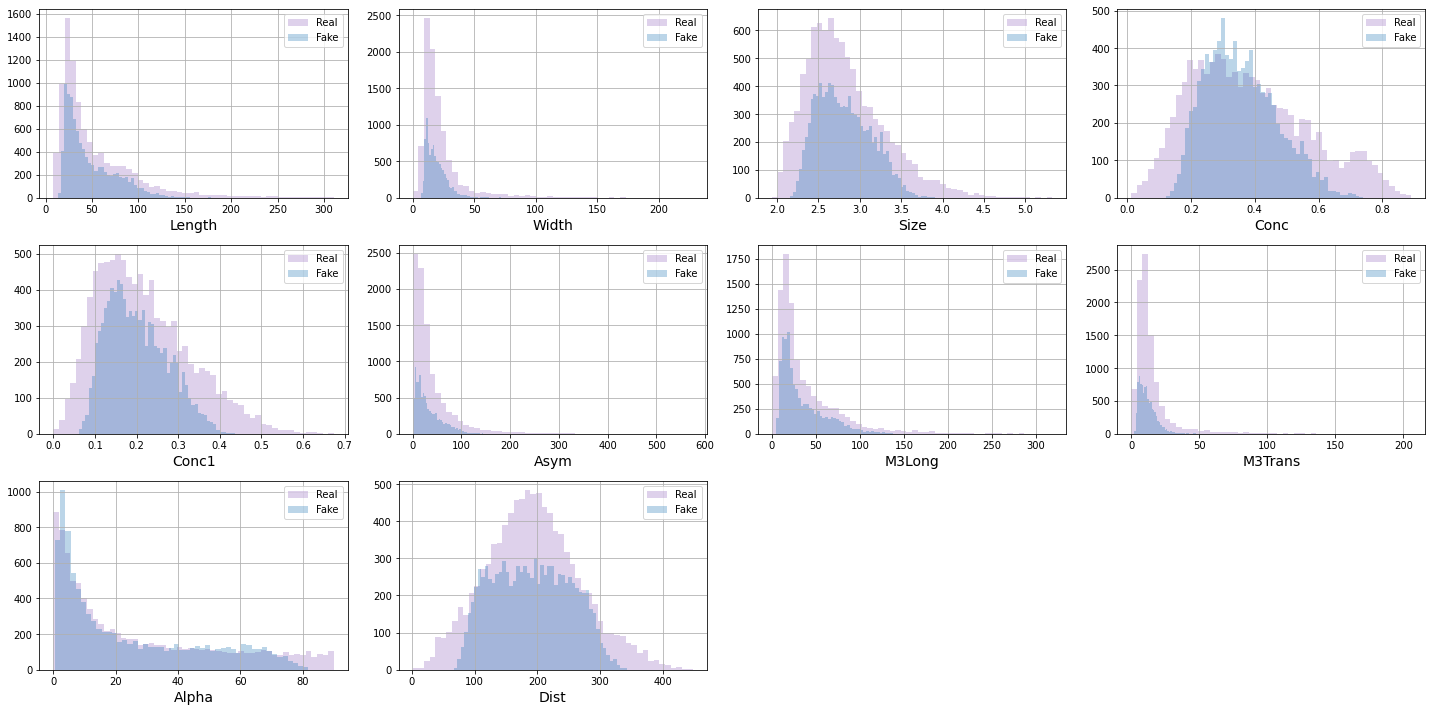

In [289]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [303]:
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, diffusionFitter.scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

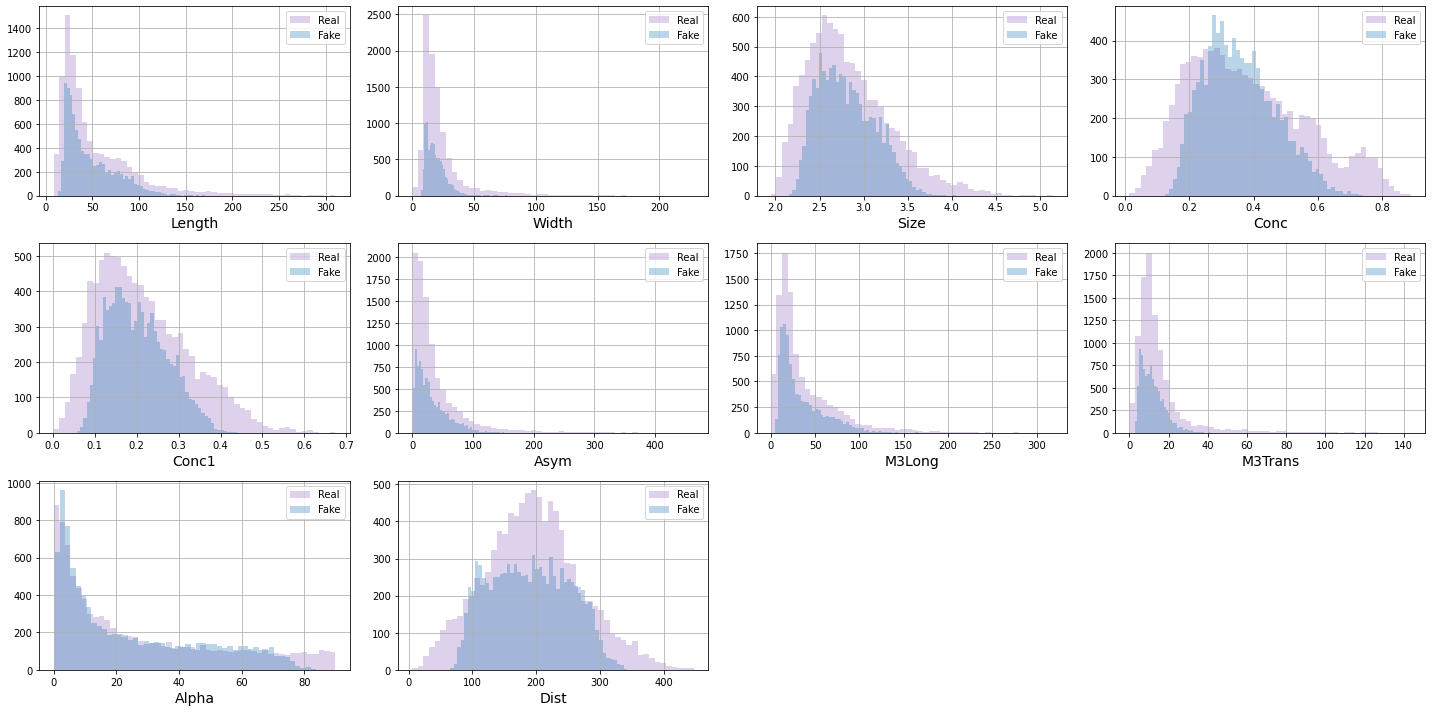

In [291]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [304]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [305]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [294]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_proba.round(), normalize=False) / len(yy_test)
print("ROC AUC =", auc)
print("accuracy =", acc)

ROC AUC = 0.8886133971545807
accuracy = 0.7637749737118822


Полученные результаты позволяют сделать вывод, что с нашей задачей генерации новых распределений по уже имеющимся лучше справляется ГАН.

Диффузионная модель должна генерировать данные так, чтоб классификатор не мог различить реальные от сгенерировать, пожтому ждем все те же идеальные результаты аук рок и акураси 0,5. Получилось, что площадь под рок кривой далеко не 1, а значит распределение похоже на реальное. Точнотсь разделения данных между класами тоже показывает, что классификатор запутался в разделении данных. Модель сработала хорошо.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!

Диффузионка не оправдала себя. Ожидала, что диффузионка будет лучше ГАНа. Полагаю, что модель стоит выбирать исходя из задачи. В нашем случае генерация по табличным данным, дискретные. Читала, что диффузионки выигрывают ГАНы на непрерывных данных. Поэтому при выборе модели нужно обязательно обратить внимание на исходные данные.

По распределению шума в диффузионке запутано, где применять коррапт, а где шедулер. Подбирала их так, чтоб было лучшее качество и меньшая отличимость генерируемых данных.